## 起源

媒體的客觀性與公正性一直是受到質疑和辯論的課題。在資訊快速傳播的時代，新聞媒體的立場和報導方式可能會影響讀者對事件的看法，並進而影響對社會議題的理解和態度。而這種影響可能是隱性的，甚至會塑造了整個社會的價值觀和信念。因此，我認為透過資料科學的方法來評估媒體的偏見可能是一個值得探討的議題。

這種探討需要將媒體報導進行客觀的分析，遠離主觀情感，透過數據和統計，來檢視不同媒體機構對特定事件或主題的報導方式。

透過資料科學的方法，我想嘗試建立一個量化模型，以探討臺灣新聞媒體在特定議題報導中的客觀性與偏見。我會嘗試使用自然語言處理（NLP）技術、機器學習算法等工具，以新聞資料為基礎，進行分析和評估。我相信這樣不僅能幫助我們更深入了解媒體報導的特徵，也能夠為提升公眾對新聞報導的辨識能力提供參考。

## 資料集

因此，我開始尋找媒體偏見的資料，看上了 [Kaggle 上一個叫做 MBIC – A Media Bias Annotation Dataset](https://www.kaggle.com/datasets/timospinde/mbic-a-media-bias-annotation-dataset) 資料集，內容如下：

In [1]:
!pip install -q sentence-transformers

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

df = pd.read_excel('./labeled_dataset.xlsx')
df = df.drop(columns='Unnamed: 0')
df.head(2)

c:\Users\David\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']



這個表格中，sentence 就是重點語句，Label Bias 是媒體偏見的標籤，這個資料集很豐富，還有類型 (左派﹑右派﹑中立)﹑完整文章﹑偏見說明。我就先用重點語句跟偏見標籤嘗試看看好了。

首先，先來看看偏見標籤的分布：


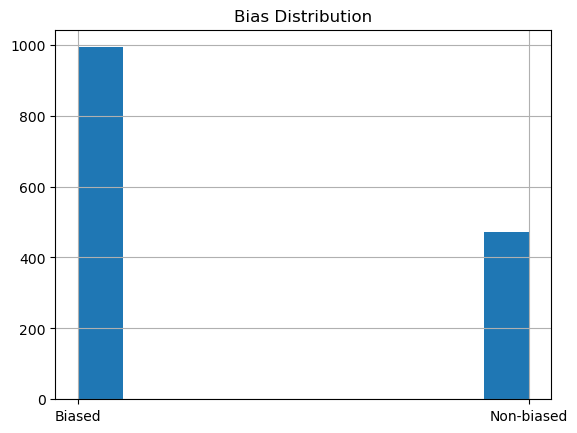

In [2]:
df = df.loc[df['article'].notna()]
df = df.loc[df['Label_bias'] != 'No agreement']
df['Label_bias'].hist()
plt.title('Bias Distribution')
plt.show()

可以看到，資料集中有偏見的筆數大約是沒有偏見的兩倍，所以我們之後在做分類器的時候要小心結果不平衡的問題。

## 模型選擇

不過很明顯，這個資料集是英文的，而臺灣的新聞是中文的，所以不能直接在這個資料集上訓練一個機器學習模型，會看不懂中文。

我也不想要把這個資料集翻譯成中文，太麻煩了。因此我需要一個已經在大量資料集下訓練好的多語言模型，並用它的詞向量去分類是否偏見。

網路上搜尋一下我找到了 SentenceTransformer，這個模型的優點是他對於每個語言不是個別訓練，而是使用 Teacher-Student 的方式將不同語言的輸出嘗試一致。Teacher-Student的意思是先訓練好一個Teacher模型，再用這個模型去「教導」其他模型，以下是這個模型官方提供的示意圖。

![Multilingual-Models - Sentence-Transformers](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/multilingual-distillation.png)

In [3]:
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

embeddings = model.encode(df['sentence'].to_list())

現在我們有了由預訓練模型產生的 768 維度的詞向量，我們要想辦法從中劃分出是媒體偏見的向量跟不是偏見的向量。

因為768個維度實在是太多了，應該很多都跟媒體偏見沒有關係，因此我用 ANOVA-F 挑出 72 (~10%) 個最相關的向量。

可能對於沒有數學背景的人有點難懂，所以這邊做個簡單說明，以下圖為例，紅色點與藍色點分別是偏見以及沒有偏見的向量， x 軸與 y 軸分別是兩個不同的維度。

![How to understand ANOVA-F for feature selection in Python. Sklearn SelectKBest with f_classif - Data Science Stack Exchange](https://i.stack.imgur.com/vkhkk.png)

可以看出來 x 軸的維度比 y 軸更適合這個資料，所以他的分數會比較高，這就是超簡易的 ANOVA-F 說明。

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

y = df['Label_bias']
fs = SelectKBest(k=72)
fs.fit(embeddings, y)
X = fs.transform(embeddings)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

挑出了向量之後就是要找一條線分開有偏見跟沒有偏見的向量們了。

如果你有機器學習背景，應該猜的到我會怎麼做﹔支援向量機 Support Vector Machine (SVM)!

![Support Vector Machine (SVM) Explained - MATLAB & Simulink](https://se.mathworks.com/discovery/support-vector-machine/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1689248289651.jpg)


支援向量機的算法簡單來說就是嘗試最大化不同族群之間的距離 (Margin)，上圖是在二維之間的示意圖。非常適合嘗試區分開來詞向量。

## 實驗結果

接下來就是把這個算法應用在我們的模型裡面了，下圖是支援向量機的準確率結果：

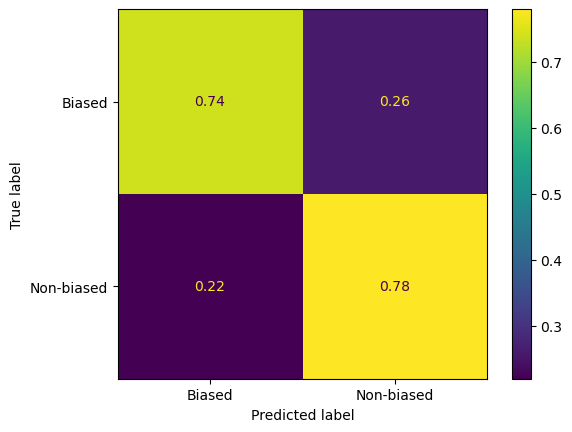

In [5]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# defining parameter range 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear'],
    "class_weight": ['balanced']
} 

clf = GridSearchCV(SVC(), param_grid, refit = True) 

# fitting the model for grid search 
clf.fit(X_train, y_train) 
# print(clf.best_params_)

# print('Train score:', clf.score(X_train, y_train))
# print('Test score:', clf.score(X_test, y_test))
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

看起來準確率不好，不過是否有偏見搞不好其實人類也很難判斷出來，而且說資料本身可能就有問題。

所以就來實際看看模型分錯的資料，自己感受一下吧：

In [6]:
y_preds = clf.predict(X)
wrong_index = y_preds != y
wrong_sentences = df['sentence'][wrong_index].to_list()

pd.options.display.max_colwidth = 200
pd.DataFrame(data={
    'SVM': y_preds[wrong_index],
    'Label' : y[wrong_index].to_list(),
    'sentence':wrong_sentences,
}).head()

,SVM,Label,sentence
0,Non-biased,Biased,The explosion of the Hispanic population has long-term job prospect consequences as well: Both legal and illegal aliens will occupy 75 percent of new American jobs in as little as five years.
1,Biased,Non-biased,"Defending Democracy Together, a group of “Never Trump” conservatives including commentator Bill Kristol, created Republican Voters Against Trump. It is among several groups on the right ― includin..."
2,Non-biased,Biased,"Voting in quasi-militarized settings was not confined to the nation’s capital. In Philadelphia, on election eve, the mayor announced a curfew that was slated to take effect an hour before its poll..."
3,Biased,Non-biased,"Planned Parenthood, the abortion industry giant says the “white supremacy” and “systemic bias in policing” that “took George Floyd’s life” are the same factors involved in “attacks” on women’s abo..."
4,Non-biased,Biased,"Track and field athletes don’t typically earn the lucrative salaries seen in the NBA, NFL, tennis or international soccer."


看起來有幾個很明顯是分錯的。不過說實話，有些我看起來也不知道到底有沒有偏見，所以就當作這個東西還能用吧。

接下來我隨便抓了 3 個不同來源的臺灣新聞文章測試模型：

### 中天新聞
文章連結 : [深綠之都局勢變了！吳子嘉曝驚人發展：她選高雄市長機會大好](https://ctinews.com/news/items/m0x7bYBKav)


In [7]:
ctinews = [
    '深綠之都局勢變了！吳子嘉曝驚人發展：她選高雄市長機會大好',
    '民進黨立委趙天麟因外遇風波，宣布退選立委選舉，對此，資深媒體人吳子嘉直言，高雄局勢開始有變化，國民黨應把國民黨智庫執行長柯志恩不分區放第一名，因為藍軍在高雄有贏的機會。',
    '吳子嘉昨天（29日）在網路節目《董事長開講》中表示，目前高雄局勢有變化，趙天麟看起來「掛掉了」，所以對柯志恩而言是最好的機會，整個非綠的選票地盤非常大。',
    '對於2026高雄市長選戰，吳子嘉直言，國民黨主席朱立倫應該要考慮高雄的布局，下去搶回來，才能讓台灣整個情勢穩定，這非常重要，因為下一次民進黨派出來參選高雄市長的人，都是「肉腳」，且一定是新潮流，而新潮流在民進黨跟地方，也受到很多人的排斥，所以國民黨下次非常有機會贏。',
    '吳子嘉認為，柯志恩應該先在不分區立委排第一名，駐點回高雄經營，他也呼籲國民黨要有這個骨氣、遠見、決心，當趙天麟出事的同時，自己若是朱立倫，立刻會做這個政治動作，要把高雄贏回來；結果很遺憾，朱立倫沒有這樣做，但是補做還來得及。'
]
pd.DataFrame({
    'bias': clf.predict(fs.transform(model.encode(ctinews))),
    'sentence': ctinews,
})

,bias,sentence
0,Non-biased,深綠之都局勢變了！吳子嘉曝驚人發展：她選高雄市長機會大好
1,Non-biased,民進黨立委趙天麟因外遇風波，宣布退選立委選舉，對此，資深媒體人吳子嘉直言，高雄局勢開始有變化，國民黨應把國民黨智庫執行長柯志恩不分區放第一名，因為藍軍在高雄有贏的機會。
2,Non-biased,吳子嘉昨天（29日）在網路節目《董事長開講》中表示，目前高雄局勢有變化，趙天麟看起來「掛掉了」，所以對柯志恩而言是最好的機會，整個非綠的選票地盤非常大。
3,Non-biased,對於2026高雄市長選戰，吳子嘉直言，國民黨主席朱立倫應該要考慮高雄的布局，下去搶回來，才能讓台灣整個情勢穩定，這非常重要，因為下一次民進黨派出來參選高雄市長的人，都是「肉腳」，且一定是新潮流，而新潮流在民進黨跟地方，也受到很多人的排斥，所以國民黨下次非常有機會贏。
4,Non-biased,吳子嘉認為，柯志恩應該先在不分區立委排第一名，駐點回高雄經營，他也呼籲國民黨要有這個骨氣、遠見、決心，當趙天麟出事的同時，自己若是朱立倫，立刻會做這個政治動作，要把高雄贏回來；結果很遺憾，朱立倫沒有這樣做，但是補做還來得及。


### 三立新聞

文章連結 : [「阿銘走遍全台各地」郭台銘最新喊話：集中所有力量，展現人民意志](https://www.setn.com/News.aspx?NewsID=1374873)

In [8]:
setn = [
    '「阿銘走遍全台各地」郭台銘最新喊話：集中所有力量，展現人民意志',
    '今（30）日晚間，郭台銘就在臉書發聲，向外界喊話「集中所有力量，展現人民的意志！」',
    '郭台銘文中提到，在最關鍵的最終階段，我們相信，有了全民的支持，台灣將走向更好的未來。這一次，各位以一張張簽名，最直接地展現了冀求改革的聲音，這超越所有黨意，以及兜兜轉轉的政治語言。',
    '投入選舉之後，郭台銘說「阿銘走遍全台各地」，我見到救人無數，但資源有限、盼不到政府支援的社福團體，以及偏鄉需要關懷的獨居長者；我見到辛苦的攤販們全力以赴，只為了讓孩子得到更好的教育。',
    '郭台銘表示，撐起中華民國的，是勤勞認真的每一位台灣人民。我的責任，就是集結所有人的聲音，為各位實現屬於台灣應有的美好未來！',
    '距離連署剩下最後幾天，郭台銘希望大家呼朋引伴「一同創造台灣的全新黃金30年，謝謝大家！」',
]
pd.DataFrame({
    'bias': clf.predict(fs.transform(model.encode(setn))),
    'sentence': setn,
})

,bias,sentence
0,Non-biased,「阿銘走遍全台各地」郭台銘最新喊話：集中所有力量，展現人民意志
1,Non-biased,今（30）日晚間，郭台銘就在臉書發聲，向外界喊話「集中所有力量，展現人民的意志！」
2,Non-biased,郭台銘文中提到，在最關鍵的最終階段，我們相信，有了全民的支持，台灣將走向更好的未來。這一次，各位以一張張簽名，最直接地展現了冀求改革的聲音，這超越所有黨意，以及兜兜轉轉的政治語言。
3,Non-biased,投入選舉之後，郭台銘說「阿銘走遍全台各地」，我見到救人無數，但資源有限、盼不到政府支援的社福團體，以及偏鄉需要關懷的獨居長者；我見到辛苦的攤販們全力以赴，只為了讓孩子得到更好的教育。
4,Non-biased,郭台銘表示，撐起中華民國的，是勤勞認真的每一位台灣人民。我的責任，就是集結所有人的聲音，為各位實現屬於台灣應有的美好未來！
5,Non-biased,距離連署剩下最後幾天，郭台銘希望大家呼朋引伴「一同創造台灣的全新黃金30年，謝謝大家！」


### 自由時報

文章連結 : [胡，怎麼說》「柯徐配」子彈快快飛 – 柯文哲應提名徐春鶯當副手！](https://talk.ltn.com.tw/article/breakingnews/4473778)

In [9]:
ltn = [
    '胡，怎麼說》「柯徐配」子彈快快飛 – 柯文哲應提名徐春鶯當副手！'
    '柯文哲似乎鐵了心，要提名曾為中共幹部、中共統戰樣板的徐春鶯為民眾黨不分區立委候選人、且排在前頭穩當選名單，甚至連徐春鶯入立法院之後，要加入內政委員會都安排好了。',
    '柯文哲大力為提名徐春鶯辯護，還反擊稱「為何劃分敵我？」不過，更多人反問柯文哲：「你為何敵我不分？」強烈質疑直指：「你根本就是敵方同路人！」',
    '在此給白黨柯黨魁一個良心的建議，就套用柯文哲最愛用的那句共言匪語「讓子彈飛」，柯文哲應該提名徐春鶯當副手，「柯徐配」一定可以讓子彈快快飛！',
    '柯文哲自己創立了民眾黨，自己提名自己為該黨總統候選人，一人英明、一人獨裁、一人獨斷，他要提名徐春鶯為不分區立委，黨內「誰敢說不」？他要提名徐春鶯為副總統候選人，黨內同樣誰敢說不？當然是他說了算！',
    '柯文哲提名徐春鶯當副手，應該如反掌折枝般容易，徐春鶯絕對不像侯友宜，人家明明不要娶你，你還限時逼婚，甚至拿著一瓶砒霜（開放式初選）、要和柯私用的糖蜜（全民調），混成兩杯交杯毒蜜，逼著一齊喝下去，那根本就是要做掉他、以奪取正的總統候選人的計謀。',
    '提名徐春鶯也不會像郭台銘那樣難搞，明明我柯的當正的，柯郭配才有機會當選，你卻搞連署要獨立參選。提名徐春鶯也不像韓國瑜那麼麻煩，中間還卡個國民黨在作梗。',
    '若論交心諂媚習近平、爭取北京支持的效果度，提名徐春鶯當副手，比侯友宜、郭台銘、韓國瑜都大的多，而且，提名徐春鶯可以藉此向習近平保證，一個中國、兩岸一家親可以在柯徐配當選後馬上就實現！',
    '「柯徐配」可以讓子彈飛、飛更快、飛更遠、飛更大，把中華民國的心射穿、把台灣民主射透透像馬蜂窩。',
    '柯文哲拿那麼大的力氣、講那麼多天大卻似是更非的理由，替徐春鶯辯護，只提名她當不分區立委，做個藍黨馬文君、吳斯懷等早已熟門熟路的事，豈不太浪費？因此，提名她當副手，柯徐配競選正副總嬂才算是實至名歸、符合柯文哲努力值及向北京的交心期望值吧！',
    '至於總統副總統選舉罷免法第20條第2項對侯選人的資格規定：回復中華民國國籍、因歸化取得中華民國國籍、大陸地區人民或香港、澳門居民經許可進入台灣地區者，不得登記為總統、副總統候選人。',
    '以上規定這對柯文哲如要提名徐春鶯為白黨副總統候選人的可能限制，但這就如柯文哲自己常把「內閣制」當做政治攻擊武器一樣，明明憲法不是內閣制，卻把內閣制當子彈，讓子彈一直飛，柯文哲應該馬上端出「柯徐配」，讓子彈飛、飛、飛....。',
]
pd.DataFrame({
    'bias': clf.predict(fs.transform(model.encode(ltn))),
    'sentence': ltn,
})

,bias,sentence
0,Non-biased,胡，怎麼說》「柯徐配」子彈快快飛 – 柯文哲應提名徐春鶯當副手！柯文哲似乎鐵了心，要提名曾為中共幹部、中共統戰樣板的徐春鶯為民眾黨不分區立委候選人、且排在前頭穩當選名單，甚至連徐春鶯入立法院之後，要加入內政委員會都安排好了。
1,Biased,柯文哲大力為提名徐春鶯辯護，還反擊稱「為何劃分敵我？」不過，更多人反問柯文哲：「你為何敵我不分？」強烈質疑直指：「你根本就是敵方同路人！」
2,Biased,在此給白黨柯黨魁一個良心的建議，就套用柯文哲最愛用的那句共言匪語「讓子彈飛」，柯文哲應該提名徐春鶯當副手，「柯徐配」一定可以讓子彈快快飛！
3,Biased,柯文哲自己創立了民眾黨，自己提名自己為該黨總統候選人，一人英明、一人獨裁、一人獨斷，他要提名徐春鶯為不分區立委，黨內「誰敢說不」？他要提名徐春鶯為副總統候選人，黨內同樣誰敢說不？當然是他說了算！
4,Biased,柯文哲提名徐春鶯當副手，應該如反掌折枝般容易，徐春鶯絕對不像侯友宜，人家明明不要娶你，你還限時逼婚，甚至拿著一瓶砒霜（開放式初選）、要和柯私用的糖蜜（全民調），混成兩杯交杯毒蜜，逼著一齊喝下去，那根本就是要做掉他、以奪取正的總統候選人的計謀。
5,Non-biased,提名徐春鶯也不會像郭台銘那樣難搞，明明我柯的當正的，柯郭配才有機會當選，你卻搞連署要獨立參選。提名徐春鶯也不像韓國瑜那麼麻煩，中間還卡個國民黨在作梗。
6,Non-biased,若論交心諂媚習近平、爭取北京支持的效果度，提名徐春鶯當副手，比侯友宜、郭台銘、韓國瑜都大的多，而且，提名徐春鶯可以藉此向習近平保證，一個中國、兩岸一家親可以在柯徐配當選後馬上就實現！
7,Biased,「柯徐配」可以讓子彈飛、飛更快、飛更遠、飛更大，把中華民國的心射穿、把台灣民主射透透像馬蜂窩。
8,Biased,柯文哲拿那麼大的力氣、講那麼多天大卻似是更非的理由，替徐春鶯辯護，只提名她當不分區立委，做個藍黨馬文君、吳斯懷等早已熟門熟路的事，豈不太浪費？因此，提名她當副手，柯徐配競選正副總嬂才算是實至名歸、符合柯文哲努力值及向北京的交心期望值吧！
9,Non-biased,至於總統副總統選舉罷免法第20條第2項對侯選人的資格規定：回復中華民國國籍、因歸化取得中華民國國籍、大陸地區人民或香港、澳門居民經許可進入台灣地區者，不得登記為總統、副總統候選人。


## 結論

這只是一個小實驗，要達到實用水準，要把模型精準度提高準確度至95%以上。

有很多東西可以做，像是利用中文資料進行模型微調是一個值得探索的方向。中文資料將為模型提供更多的多樣性和深度，進而提高模型對新聞偏見的辨識能力。

這個模型可以應用於媒體排行榜的建立之類的，這樣的排行榜可以幫助人們更好地了解和評估各種媒體的客觀性和偏見程度，對於新聞產業和公眾觀點形成都有重要影響。
